Using device: cuda
Processing folder: /home/khare.aks/Dataset/combined/COVID/COVID
Processing folder: /home/khare.aks/Dataset/combined/NORMAL/NORMAL
Processing folder: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA
Processing folder: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis


/home/khare.aks/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khare.aks/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Train Loss: 0.5457, Train Acc: 0.8006
Val Loss: 0.6258, Val Acc: 0.7821
Epoch 2/20
Train Loss: 0.3491, Train Acc: 0.8779
Val Loss: 0.2894, Val Acc: 0.9016
Epoch 3/20
Train Loss: 0.2812, Train Acc: 0.9023
Val Loss: 0.2229, Val Acc: 0.9142
Epoch 4/20
Train Loss: 0.2460, Train Acc: 0.9160
Val Loss: 0.4891, Val Acc: 0.8637
Epoch 5/20
Train Loss: 0.2329, Train Acc: 0.9217
Val Loss: 0.2462, Val Acc: 0.9106
Epoch 6/20
Train Loss: 0.1982, Train Acc: 0.9338
Val Loss: 0.3841, Val Acc: 0.8547
Epoch 7/20
Train Loss: 0.1248, Train Acc: 0.9581
Val Loss: 0.1035, Val Acc: 0.9628
Epoch 8/20
Train Loss: 0.1002, Train Acc: 0.9668
Val Loss: 0.0973, Val Acc: 0.9634
Epoch 9/20
Train Loss: 0.0913, Train Acc: 0.9687
Val Loss: 0.0864, Val Acc: 0.9652
Epoch 10/20
Train Loss: 0.0852, Train Acc: 0.9712
Val Loss: 0.0964, Val Acc: 0.9652
Epoch 11/20
Train Loss: 0.0745, Train Acc: 0.9751
Val Loss: 0.0885, Val Acc: 0.9700
Epoch 12/20
Train Loss: 0.0693, Train Acc: 0.9756
Val Loss: 0.0850, Val Acc: 0.9658
E

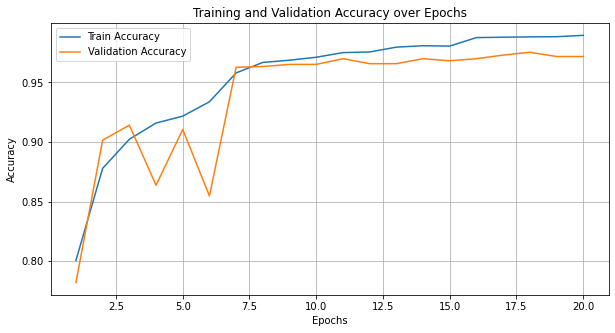


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       154
           1       0.97      0.99      0.98       919
           2       0.99      0.97      0.98       414
           3       0.95      0.89      0.92       179

    accuracy                           0.97      1666
   macro avg       0.97      0.96      0.97      1666
weighted avg       0.97      0.97      0.97      1666



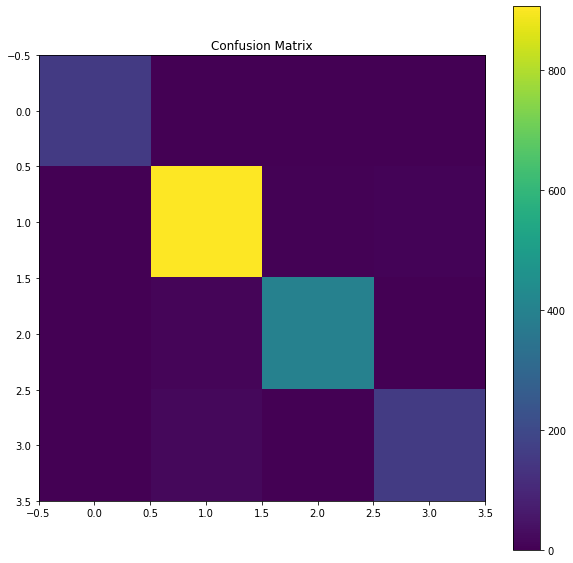

Test Accuracy: 0.9718


In [10]:
# Libraries
import os
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Data loading and preparation
data_dir = '/home/khare.aks/Dataset/combined/'

# Initialize lists for image paths and labels
image_paths = []
labels = []

# Traverse dataset
for folder in os.listdir(data_dir):
    outer_folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(outer_folder_path):
        inner_folder_path = os.path.join(outer_folder_path, folder)
        if os.path.isdir(inner_folder_path):
            print(f"Processing folder: {inner_folder_path}")
            for file in os.listdir(inner_folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    file_path = os.path.join(inner_folder_path, file)
                    image_paths.append(file_path)
                    labels.append(folder)

# Create DataFrame
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})
label_mapping = {label: idx for idx, label in enumerate(data_frame['labels'].unique())}
data_frame['labels'] = data_frame['labels'].map(label_mapping)

# Split data
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = {label: idx for idx, label in enumerate(dataframe['labels'].unique())}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        try:
            img_path = self.dataframe.iloc[idx]['image_paths']
            label = self.dataframe.iloc[idx]['labels']
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return None

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
batch_size = 16

train_dataset = ImageDataset(train_df, transform=transform)
valid_dataset = ImageDataset(valid_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(label_mapping))
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    early_stopping_patience = 5

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_acc = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item()

        val_loss /= len(valid_loader)
        val_acc /= len(valid_loader.dataset)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            save_checkpoint(model, optimizer, epoch, val_loss, best_val_loss, 'resnet101_chest_xray_1.pth')
        else:
            no_improve_epochs += 1

        scheduler.step(val_loss)

        if no_improve_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('training_validation_accuracy_resnet.png')
    plt.show()
    plt.close()

# Checkpoint functions
def save_checkpoint(model, optimizer, epoch, val_loss, best_val_loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'best_val_loss': best_val_loss,
        'class_to_idx': train_dataset.class_to_idx
    }
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer=None):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['val_loss'], checkpoint['best_val_loss']

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.savefig('confusion_matrix_resnet.png')
    plt.show()
    plt.close()

    return accuracy_score(all_labels, all_preds)

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler)

# Load best model and evaluate
model.load_state_dict(torch.load('resnet101_chest_xray_1.pth')['model_state_dict'])
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")
